In [19]:
%matplotlib inline

import os
import gzip
import csv
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
#print plt.style.available
plt.style.use('seaborn-colorblind')

os.getcwd()

'/home/droski/kaggle/shelter-animals-outcomes'

In [47]:
sample = pd.read_csv(u'data/sample_submission.csv.gz')
test = pd.read_csv(u'data/test.csv.gz')
train = pd.read_csv(u'data/train.csv.gz')

test['fileName'] = 'test'
train['fileName'] = 'train'

full = pd.concat((train, test))

In [51]:
full['unitOfTime'] = train.AgeuponOutcome.apply(lambda x: re.sub('s$', '', str(x).split(' ')[-1]))
full['timeVal'] = train.AgeuponOutcome.apply(lambda x: str(x).split(' ')[0])

daysMultiplier = pd.DataFrame.from_dict([{np.nan: 0, 'day' : 1, 'week' : 7, 'month' : 30, 'year' : 365}]).T.reset_index()
daysMultiplier.columns = ['unitOfTime', 'daysMultiplier']
full = pd.merge(full, daysMultiplier, on='unitOfTime', how='left', suffixes=['','_y'])
full['ageInDays'] = full['timeVal'].astype(float) * full['daysMultiplier']
full['ageGrp'] = full['ageInDays'].apply(lambda x: 'Adult' if x > 365 else 'Baby')

In [52]:
full.head()

,AgeuponOutcome,AnimalID,AnimalType,Breed,Color,DateTime,ID,Name,OutcomeSubtype,OutcomeType,SexuponOutcome,fileName,unitOfTime,timeVal,daysMultiplier,ageInDays,daysMultiplier_y,daysMultiplier_y,daysMultiplier_y,ageGrp
0,1 year,A671945,Dog,Shetland Sheepdog Mix,Brown/White,2014-02-12 18:22:00,NaN,Hambone,NaN,Return_to_owner,Neutered Male,train,year,1,365.0,365.0,365.0,365.0,365.0,Baby
1,1 year,A656520,Cat,Domestic Shorthair Mix,Cream Tabby,2013-10-13 12:44:00,NaN,Emily,Suffering,Euthanasia,Spayed Female,train,year,1,365.0,365.0,365.0,365.0,365.0,Baby
2,2 years,A686464,Dog,Pit Bull Mix,Blue/White,2015-01-31 12:28:00,NaN,Pearce,Foster,Adoption,Neutered Male,train,year,2,365.0,730.0,365.0,365.0,365.0,Adult
3,3 weeks,A683430,Cat,Domestic Shorthair Mix,Blue Cream,2014-07-11 19:09:00,NaN,NaN,Partner,Transfer,Intact Male,train,week,3,7.0,21.0,7.0,7.0,7.0,Baby
4,2 years,A667013,Dog,Lhasa Apso/Miniature Poodle,Tan,2013-11-15 12:52:00,NaN,NaN,Partner,Transfer,Neutered Male,train,year,2,365.0,730.0,365.0,365.0,365.0,Adult


In [45]:
full['SexuponOutcome'].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

OutcomeType  Adoption  Died  Euthanasia  Return_to_owner  Transfer
AnimalType                                                        
Cat              4272   147         710              500      5505
Dog              6497    50         845             4286      3917


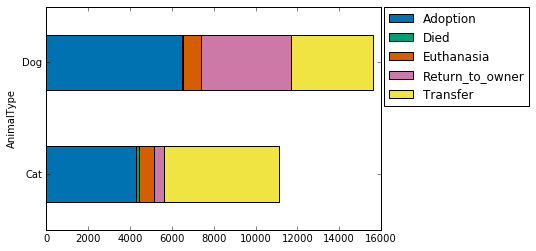

In [33]:
outcomes = train.groupby(['AnimalType', 'OutcomeType'])\
            ['AnimalID'].count().unstack()

print outcomes    
outcomes_plot = outcomes.plot.barh(stacked=True)
outcomes_plot.legend(loc=(1.01,.555), ncol=1)


In [35]:
full.timeVal.unique()

array(['1', '2', '3', '5', '4', '10', '6', '7', '12', '9', '11', '8', '15',
       '0', '14', '16', '13', 'nan', '17', '18', '19', '20'], dtype=object)

In [152]:
full['unitOfTime'].unique()

array(['year', 'week', 'month', 'day', 'nan'], dtype=object)

In [153]:
full['timeVal'].unique()

array(['1', '2', '3', '5', '4', '10', '6', '7', '12', '9', '11', '8', '15',
       '0', '14', '16', '13', 'nan', '17', '18', '19', '20'], dtype=object)

In [156]:
full.tail()

,AgeuponOutcome,AnimalID,AnimalType,Breed,Color,DateTime,ID,Name,OutcomeSubtype,OutcomeType,SexuponOutcome,fileName,unitOfTime,timeVal
11451,2 months,NaN,Cat,Domestic Shorthair Mix,Black,2014-07-08 14:50:00,11452.0,NaN,NaN,NaN,Neutered Male,test,year,8
11452,2 weeks,NaN,Cat,Domestic Shorthair Mix,Blue,2014-10-21 12:57:00,11453.0,NaN,NaN,NaN,Intact Female,test,year,4
11453,1 year,NaN,Cat,Domestic Shorthair Mix,Calico,2014-09-29 09:00:00,11454.0,NaN,NaN,NaN,Intact Female,test,year,3
11454,6 years,NaN,Dog,German Shepherd Mix,Black/Tan,2015-09-05 17:16:00,11455.0,Rambo,NaN,NaN,Neutered Male,test,year,9
11455,4 years,NaN,Dog,Labrador Retriever,Cream,2014-07-12 18:40:00,11456.0,Gusto,NaN,NaN,Intact Male,test,month,3


In [129]:
from bokeh.charts import Bar, TimeSeries, output_file, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [45]:
outcomes = train.groupby(['AnimalType', 'OutcomeType'])\
            ['AnimalID'].count().reset_index()
outcomes.columns = ['AnimalType', 'OutcomeType', 'num_animals']
    
hover = HoverTool(
        tooltips=[
            ("Animal", "$x"),  
            ("Outcome", "@OutcomeType"),
            ("Num", "@height{int}"),
        ]
    )
p = Bar(outcomes, label='AnimalType', values='num_animals', agg='sum',\
        stack='OutcomeType', legend='top_left', plot_height=600,\
        tools=[hover]) 
#source = ColumnDataSource(p)
show(p)

In [100]:
train['DateTime'] = pd.to_datetime(train.DateTime)
train['Date'] = train['DateTime'].dt.date
train['Month'] = train['DateTime'].dt.month

In [128]:
ocTm = train.groupby(['OutcomeType','Date'])\
                    ['AnimalID'].count().reset_index()
ocTm = ocTm[ocTm.OutcomeType == 'Adoption']
ocTm.columns = ['OutcomeType', 'Date', 'num_animals']

#xyvalues = pd.DataFrame(dict(
#        adoption = ocTm[ocTm.OutcomeType == 'Adoption']['num_animals'],
#        Date = ocTm[ocTm.OutcomeType == 'Adoption']['Month']
#))

t = TimeSeries(ocTm, index='Date')
show(t)

AttributeError: unexpected attribute 'index' to Chart, possible attributes are above, background_fill_alpha, background_fill_color, below, border_fill_alpha, border_fill_color, disabled, extra_x_ranges, extra_y_ranges, h_symmetry, hidpi, left, legend, lod_factor, lod_interval, lod_threshold, lod_timeout, logo, min_border, min_border_bottom, min_border_left, min_border_right, min_border_top, name, outline_line_alpha, outline_line_cap, outline_line_color, outline_line_dash, outline_line_dash_offset, outline_line_join, outline_line_width, plot_height, plot_width, renderers, responsive, right, tags, title, title_standoff, title_text_align, title_text_alpha, title_text_baseline, title_text_color, title_text_font, title_text_font_size, title_text_font_style, tool_events, toolbar_location, tools, v_symmetry, webgl, x_mapper_type, x_range, xgrid, xlabel, xscale, y_mapper_type, y_range, ygrid, ylabel or yscale

In [127]:
ocTm

,OutcomeType,Date,num_animals,index
0,Adoption,2013-10-01,7,0
1,Adoption,2013-10-02,11,1
2,Adoption,2013-10-03,6,2
3,Adoption,2013-10-04,7,3
4,Adoption,2013-10-05,24,4
5,Adoption,2013-10-06,18,5
6,Adoption,2013-10-07,11,6
7,Adoption,2013-10-08,8,7
8,Adoption,2013-10-09,10,8
9,Adoption,2013-10-10,13,9
